In [1]:
import numpy as np
import h5py # for reading in .h5 dust files
import matplotlib.pyplot as plt
import matplotlib
from astropy import constants as cst
from astropy import units as u
#%matplotlib widget
import healpy as hp
from aqn import *
from constants import *

Loaded AQN script


In [2]:
dust_directory = '/data4/msekatchev/leike2020/'
%ls $dust_directory

ls: cannot access '/data4/msekatchev/leike2020/': No such file or directory


In [3]:
# read in dust cube, this may take a while
filename = "samples.h5"
filepointer = h5py.File(dust_directory + filename, "r")
# https://stackoverflow.com/questions/28170623/how-to-read-hdf5-files-in-python
dust_key = list(filepointer.keys())[0]
dust = filepointer[dust_key][()] 
filepointer.close()

In [4]:
# work with the first of the 12 dust samples for now
dust_s1 = dust[0]
np.max(dust_s1[:,:,270]) * 880

247.12056159973145

In [5]:
# cube dimensions
cube_shape = np.shape(dust_s1)
cube_x_max, cube_y_max, cube_z_max = cube_shape[0], cube_shape[1], cube_shape[2]
print(cube_x_max, "x", cube_y_max,"x", cube_z_max)

740 x 740 x 540


In [6]:
NSIDE = 2**9
NPIX = hp.nside2npix(NSIDE)
dOmega = hp.nside2pixarea(nside=NSIDE)
theta, phi = hp.pix2ang(nside = NSIDE, ipix = list(range(NPIX)))


In [7]:
print(NPIX)
print(2**8)
print(hp.nside2resol(nside=NSIDE, arcmin=True), "should be less than ~9 arcmin atan(1/370)")
print((np.arctan(1/(max(cube_shape)/2))*u.rad).to(u.arcmin))

3145728
256
6.870972823634812 should be less than ~9 arcmin atan(1/370)
9.291184865849806 arcmin


In [8]:
# ----------- DM Halo Model -----------
m_AQN_kg = 0.07*u.kg
R_AQN = calc_R_AQN(m_AQN_kg)

rho_0h = 0.0106 * u.solMass / u.pc**3
r_h = 19.0 * u.kpc

def rho_halo(R_kpc):
    return rho_0h.to(u.kg/u.m**3) / ((R_kpc/r_h)*(1+R_kpc/r_h)**2)

def n_halo(R_pc):
    return rho_halo((R_pc).to(u.kpc)) / m_AQN_kg

In [9]:
# ----------- Leike Dust Model -------
def n_gas_component(x, y, z):
    x_index = x + round(cube_x_max/2)
    y_index = y + round(cube_y_max/2)
    z_index = z + round(cube_z_max/2)
    
    n_gas = np.zeros(np.shape(x)) - 1
    i_in_cube = (abs(x) < cube_x_max/2) & (abs(y) < cube_y_max/2) & (abs(z) < cube_z_max/2) 
    n_gas[i_in_cube] = dust_s1[x_index[i_in_cube], y_index[i_in_cube], z_index[i_in_cube]] 
    
    return np.array(n_gas, dtype = np.float64) * 880 * 1/u.cm**3

In [10]:
# x_index = x + round(cube_x_max/2)
# y_index = y + round(cube_y_max/2)
# z_index = z + round(cube_z_max/2)

# xbounds = np.where(abs(x)<cube_x_max/2)
# ybounds = np.where(abs(y)<cube_y_max/2)
# zbounds = np.where(abs(z)<cube_z_max/2)

In [42]:
# ---------- Galex Parameters ---------
wavel_min = 1350 * u.Angstrom
wavel_max = 1750 * u.Angstrom
print("Galex data is", wavel_min.value, "-", wavel_max)
f_max = (cst.c.cgs / wavel_min.to(u.cm)).to(u.Hz)
f_min = (cst.c.cgs / wavel_max.to(u.cm)).to(u.Hz)
print("       ","{:e}".format(f_min.to(u.GHz).value), "-", "{:e}".format(f_max.to(u.GHz)))

def response_func(wavelength):
    return 1 * wavelength / wavelength #wavelength/(wavel_max - wavel_min).value

Galex data is 1350.0 - 1750.0 Angstrom
        1.713100e+06 - 2.220685e+06 GHz


In [12]:
low_lat_filter = (np.degrees(theta) > 73) & (np.degrees(theta) < 113)
high_lat_filter = (np.degrees(theta) < 73) | (np.degrees(theta) > 113)

# array for wavelengths in galex waveband
wavelength_band_resolution = 30
wavelength_band = np.arange(wavel_min.value, wavel_max.value, wavelength_band_resolution)
frequency_band = (cst.c / (wavelength_band*u.Angstrom).to(u.m)).to(u.Hz)
conversion_array = (1*u.erg/u.s/u.Hz/u.cm**2/u.sr).to(u.photon / u.cm**2 / u.s / u.Angstrom / u.sr, 
                                                      u.spectral_density(wavelength_band*u.Angstrom)) * response_func(wavelength_band)/ (u.erg/u.s/u.Hz/u.cm**2/u.sr)


In [13]:
theta_all = theta
phi_all = phi

theta = theta[0:4]
phi = phi[0:4]

phi

array([0.78539816, 2.35619449, 3.92699082, 5.49778714])

In [14]:
# array of distance elements
cube_R_max = round(np.sqrt((cube_x_max/2)**2 + (cube_z_max/2)**2))
print(cube_R_max)

dl =  1 * u.pc
l_min, l_max = 0, cube_R_max
l_list = np.arange(l_min,l_max,dl.value)[:, np.newaxis]

# 2D array of distance elements along each sightline
l_array = np.ones((len(l_list),len(theta))) * l_list
# l_array[:,low_lat_filter] = 0

# (l,theta,phi) -> (x,y,z)
x = l_array * np.sin(theta) * np.cos(phi)
y = l_array * np.sin(theta) * np.sin(phi)
z = l_array * np.cos(theta)

x = np.round(x)
y = np.round(y)
z = np.round(z)
R = l_array

x = np.array(x, dtype = np.int16)
y = np.array(y, dtype = np.int16)
z = np.array(z, dtype = np.int16)
R = np.array(R, dtype = np.int16)

xbounds = np.where(abs(x)<cube_x_max/2)
ybounds = np.where(abs(y)<cube_y_max/2)
zbounds = np.where(abs(z)<cube_z_max/2)

458


In [15]:
h_func_cutoff = 17 + 12*np.log(2)
def h(x):
    return_array = np.copy(x)
    return_array[np.where(x<1)] = (17 - 12*np.log(x[np.where(x<1)]/2))
    return_array[np.where(x>=1)] = h_func_cutoff
    return return_array

# spectral_surface_emissivity_u_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
# def spectral_surface_emissivity(T, frequency_band):
#     T = T * eV_to_erg
#     w_div_T = (2*np.pi*Hz_to_erg)*frequency_band[None,None,:] * (np.ones((len(l_list),len(theta), len(frequency_band))) / T)
#     return spectral_surface_emissivity_u_factor * 4/45 * T**3 * cst.alpha ** (5/2) * 1/np.pi * (T/(m_e_eV*eV_to_erg))**(1/4) * (1 + w_div_T) * np.exp(- w_div_T) * h(w_div_T)

# def spectral_spatial_emissivity_cold(n_AQN, n_bar, Dv, f, g, frequency_band):
#     T_AQN = T_AQN_analytical(n_cold, Dv, f, g)
#     dFdw = spectral_surface_emissivity(T_AQN[:,:,None], frequency_band)
#     return dFdw 

# def spectral_spatial_emissivity_hot(n_AQN, n_bar, Dv, f, g, T_gas, R_AQN, nu):
#     T_neu_eV = T_AQN_analytical(n_bar, Dv, f, g)
#     T_ion_eV = T_AQN_ionized(n_bar, Dv, f, g, T_gas, R_AQN)
#     T_AQN = T_neu_eV.copy()                   # don't need this, use T_neu_eV
#     ion_greater_neu = np.where(T_ion_eV > T_neu_eV)
#     T_AQN[ion_greater_neu] = T_ion_eV[ion_greater_neu]
#     dFdw = spectral_surface_emissivity(T_AQN[:,:,None], frequency_band)
#     #dF = np.sum(dFdw,2)
#     return dFdw

# def func(n_c, frequency_band):
#     epsilon = np.sum(((spectral_spatial_emissivity_cold(n_aqn, n_c, Dv, f, g, frequency_band))*
#         conversion_array),2) * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)
#     return epsilon.value



#dfdlambda = sum(func(n_cold, frequency_band)) / (4*np.pi) * (dl.cgs).value * dOmega * 1/dOmega
#dfdlambda[low_lat_filter] = 0

In [16]:
n_cold = n_gas_component(x,y,z)
n_cold

<Quantity [[ 2.41156975e-01,  2.41156975e-01,  2.41156975e-01,
             2.41156975e-01],
           [ 2.80680852e-01,  2.80680852e-01,  2.80680852e-01,
             2.80680852e-01],
           [ 2.12012234e-01,  2.12012234e-01,  2.12012234e-01,
             2.12012234e-01],
           ...,
           [-8.80000000e+02, -8.80000000e+02, -8.80000000e+02,
            -8.80000000e+02],
           [-8.80000000e+02, -8.80000000e+02, -8.80000000e+02,
            -8.80000000e+02],
           [-8.80000000e+02, -8.80000000e+02, -8.80000000e+02,
            -8.80000000e+02]] 1 / cm3>

(0.0, 1.0)

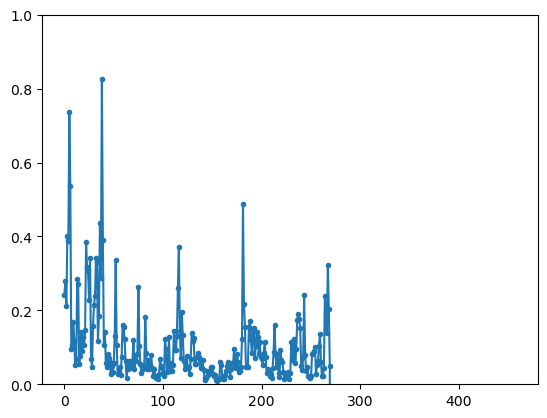

In [17]:
plt.plot(n_cold[:,3], ".-")

plt.ylim([0,1])

In [18]:
def T_AQN_analytical(n_bar, Dv, f, g):
    T_AQN = np.copy(n_bar.value) # zeros_like
    #n_bar_valid = (n_bar >= 0)
    n_bar_valid = np.where(T_AQN >= 0)
    n_bar_invalid = np.where(T_AQN < 0)
    T_AQN[n_bar_valid] = ((1-g) * np.pi * 3/16 * 1/(cst.alpha**(5/2)) * (m_e_erg)**(1/4) * 
             (E_ann_GeV * GeV_to_erg) * f * Dv * ((n_bar[n_bar_valid]).to(1/u.cm**3) * invcm_to_erg**3))**(4/17) * erg_to_eV
    T_AQN[n_bar_invalid] = -1
    return T_AQN * u.eV

In [19]:
T_AQN = T_AQN_analytical(n_cold, Dv, f, g)
T_AQN[15]

<Quantity [0.14348844, 0.14348844, 0.14348844, 0.14348844] eV>

(0.0, 0.4)

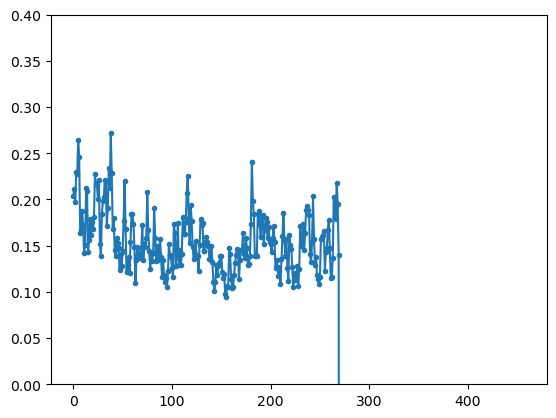

In [20]:
plt.plot(T_AQN[:,0], ".-")

plt.ylim([0,0.4])

In [21]:
# # Original function:
# # erg Hz^-1 s^-1 cm^-2
# # nu Hz
# # T eV
# def spectral_surface_emissivity(T, nu):
#     T = T * eV_to_erg
#     w = 2 * np.pi * nu * Hz_to_erg
#     unit_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
#     #                ^ 1/seconds           ^ 1/area                          ^ 1/frequency and energy
#     return unit_factor * 4/45 * T**3 * cst.alpha ** (5/2) * 1/np.pi * (T/(m_e_eV*eV_to_erg))**(1/4) * (1 + w/T) * np.exp(- w/T) * h(w/T)



In [22]:
#spectral_surface_emissivity(np.array([1]),1)

In [23]:
# spectral_surface_emissivity(np.array([T_AQN[0,0].value])*u.eV,frequency_band)

In [24]:
# # Function to work with arrays
# spectral_surface_emissivity_u_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
# def spectral_surface_emissivity(T, frequency_band):
#     T = T * eV_to_erg
#     w_div_T = (2*np.pi*Hz_to_erg)*frequency_band[None,None,:] * (np.ones((len(l_list),len(theta), len(frequency_band))) / T)
#     return spectral_surface_emissivity_u_factor * 4/45 * T**3 * cst.alpha ** (5/2) * 1/np.pi * (T/(m_e_eV*eV_to_erg))**(1/4) * (1 + w_div_T) * np.exp(- w_div_T) * h(w_div_T)

In [25]:
# spectral_surface_emissivity_u_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
# def spectral_surface_emissivity(T, frequency_band):
#     dfdw = np.copy(T.value)
#     T_valid = np.where(T >= 0)
#     T_invalid = np.where(T < 0)
    
#     T[T_valid] = T[T_valid] * eV_to_erg

#     w_div_T = (2*np.pi*Hz_to_erg)*frequency_band[None,None,:] * (np.ones((len(l_list),len(theta), len(frequency_band))) / T)
#     w_div_T[T_valid]
#     dfdw[T_valid] = spectral_surface_emissivity_u_factor * 4/45 * \
#                     T[T_valid]**3 * cst.alpha ** (5/2) * 1/np.pi * \
#                    (T[T_valid]/(m_e_eV*eV_to_erg))**(1/4) * \
#                    (1 + w_div_T[T_valid]) * \
#                     np.exp(- w_div_T[T_valid]) * \
#                     h(w_div_T[T_valid])
#     dfdw[T_invalid] = -1
#     return dfdw


# # erg Hz^-1 s^-1 cm^-2

In [1]:
spectral_surface_emissivity_u_factor = (1 / cst.hbar.cgs) * (1/(cst.hbar.cgs * cst.c.cgs))**2 * (cst.hbar.cgs * 1/u.Hz * 1/u.s)
def spectral_surface_emissivity(T, frequency_band):
    res = np.zeros(np.shape(T)) * u.photon / u.cm**2 / u.s / u.Angstrom / u.sr  # * u.erg/u.Hz/u.s/u.cm**2/u.sr# # 
    res[T<0] = -1 * u.photon / u.cm**2 / u.s / u.Angstrom / u.sr  # * u.erg/u.Hz/u.s/u.cm**2/u.sr 
    f = frequency_band[0]
    T = T * eV_to_erg
    for i in range(len(frequency_band)):
        w_div_T = (2*np.pi*Hz_to_erg)*frequency_band[i] / T
        res[T>0] += spectral_surface_emissivity_u_factor * 4/45 * \
                    T[T>0]**3 * cst.alpha ** (5/2) * 1/np.pi * \
                   (T[T>0]/(m_e_eV*eV_to_erg))**(1/4) * \
                   (1 + w_div_T[T>0]) * np.exp(- w_div_T[T>0]) * h(w_div_T[T>0]) * 1/(dOmega*u.sr) * conversion_array[i] 
    return res 


NameError: name 'cst' is not defined

In [30]:
# what is my conversion vector?
conversion_array[1]

<Quantity 1.09361607e+23 Hz ph / (Angstrom erg)>

In [35]:
# simple single point test
spectral_surface_emissivity(np.array([T_AQN[0,0].value])*u.eV,frequency_band)

<Quantity [3.50924243e-20] erg / (cm2 Hz s sr)>

In [36]:
dFdw = spectral_surface_emissivity(T_AQN, frequency_band)
dFdw

<Quantity [[ 3.50924243e-20,  3.50924243e-20,  3.50924243e-20,
             3.50924243e-20],
           [ 1.33243590e-19,  1.33243590e-19,  1.33243590e-19,
             1.33243590e-19],
           [ 1.09241363e-20,  1.09241363e-20,  1.09241363e-20,
             1.09241363e-20],
           ...,
           [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
            -1.00000000e+00],
           [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
            -1.00000000e+00],
           [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
            -1.00000000e+00]] erg / (cm2 Hz s sr)>

In [37]:
dFdw[np.where(dFdw<0)] = 0

In [38]:
epsilon = dFdw * 4 * np.pi * R_AQN**2 * n_AQN.to(1/u.cm**3)
epsilon

<Quantity [[9.69245881e-52, 9.69245881e-52, 9.69245881e-52,
            9.69245881e-52],
           [3.68016184e-51, 3.68016184e-51, 3.68016184e-51,
            3.68016184e-51],
           [3.01722505e-52, 3.01722505e-52, 3.01722505e-52,
            3.01722505e-52],
           ...,
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
            0.00000000e+00]] erg / (cm3 Hz s sr)>

In [39]:
dfdlambda = sum(epsilon) / (4*np.pi) * dl.cgs #* 1*u.sr

In [41]:
dfdlambda * 10**23

<Quantity [5.815502602854759e-07, 5.815502602854759e-07,
           5.815502602854759e-07, 5.815502602854759e-07] erg / (cm2 Hz s sr)>

In [36]:
dOmega

3.994741635118857e-06

In [43]:
np.log10(dfdlambda.value)

array([-11.68362605, -11.68362605, -11.68362605, -11.68362605])

In [490]:
#dfdlambda[low_lat_filter] = 0

In [419]:
f1 = plt.figure(figsize=(7.5,4.5), dpi=1000)
# rotation in (lat, long, psi)
hp.mollview(np.log10(dfdlambda.value), 
            title="FUV Emissions from AQN Annihilation", 
            rot=(0,0,0),
            cmap='gist_rainbow', 
            fig=f1, 
            unit="")

#hp.graticule(dmer=360,dpar=360,alpha=0)  
hp.graticule(dmer=30,dpar=30, alpha=1, color="white", linewidth=10)
longitude_labels = [150,120,90,60,30,0,330,300,270,240,210]
for i in range(len(longitude_labels)):
    plt.text((-5+i)*0.34,0.1,str(longitude_labels[i])+"$^\circ$",size=7,horizontalalignment="center")
    
latitude_labels = [-60,-30,0,30,60]
plt.text(-2.01,-0.41,"-30$^\circ$",size=7,horizontalalignment="center") 
plt.text(-2.1,0,"0$^\circ$",size=7,horizontalalignment="center")
plt.text(-2,0.39,"30$^\circ$",size=7,horizontalalignment="center") 
plt.text(-1.5,0.73,"60$^\circ$",size=7,horizontalalignment="center") 
plt.text(-1.51,-0.8,"-60$^\circ$",size=7,horizontalalignment="center") 

plt.text(0,-1.10,"Logarithmic",size=9,horizontalalignment="center")
plt.text(0,-1.37,"photons$\,\cdot\,$cm$^{-2}\cdot$A$^{-1}\cdot$s$^{-1}\cdot$sr$^{-1}$",size=10,horizontalalignment="center")

plt.savefig("cube_projection_testing.png")
plt.show()

TypeError: bad number of pixels

<Figure size 7500x4500 with 0 Axes>

In [5]:
# work out one side of the cube for now. The y+ side.
# largest opening angle:
phi_max_rad = np.pi/4
phi_max_deg = np.degrees(phi_max_rad)
theta_max_rad = np.arctan(270/370)
theta_max_deg = np.degrees(theta_max_rad)

print("first, work with projections on one side of the cube")
print("theta ranging from", 90-theta_max_deg, "to", 90+theta_max_deg)
print("phi ranging from", -phi_max_deg, "to", phi_max_deg)
side_filter_theta = ((np.degrees(theta) > 90-theta_max_deg) & (np.degrees(theta) < 90+theta_max_deg))
side_filter_phi = ((np.degrees(phi) > -phi_max_deg) & (np.degrees(phi) < phi_max_deg))

side_y_plus = (side_filter_theta & side_filter_phi)

first, work with projections on one side of the cube
theta ranging from 53.880659150520245 to 126.11934084947976
phi ranging from -45.0 to 45.0


In [6]:
count_pixels = np.zeros(NPIX)
count_pixels[side_y_plus] = 1
pixel_count = np.sum(count_pixels)
print("there are", int(pixel_count),"pixels in the selected side") # seems too low, only 8%

there are 3616 pixels in the selected side


In [7]:
I_tot = np.zeros([NPIX])
I_tot[side_y_plus] = 1

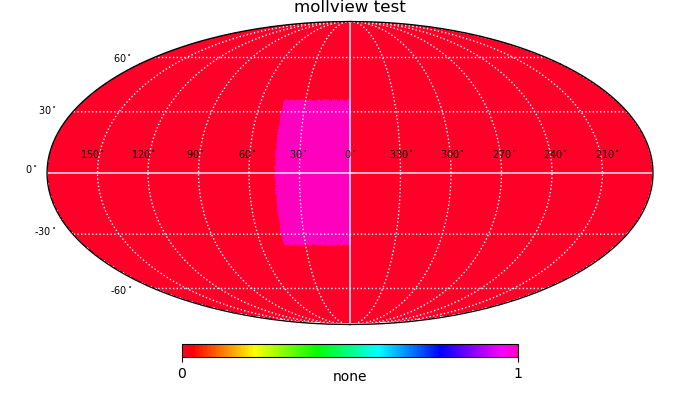

In [8]:
#side_filter_theta = ((np.degrees(theta) > -theta_max_deg) & (np.degrees(theta) < theta_max_deg))
#side_filter_phi = ((np.degrees(phi) > -theta_max_deg) & (np.degrees(phi) < theta_max_deg))


f1 = plt.figure(figsize=(7,4), dpi=100) # change back to 1000
# rotation in (lat, long, psi)
hp.mollview(I_tot, # <---------
            title="mollview test", 
            rot=(0,0,0),
            cmap='gist_rainbow', 
            fig=f1, 
            unit="")

#hp.graticule(dmer=360,dpar=360,alpha=0)  
hp.graticule(dmer=30,dpar=30, alpha=1, color="white", linewidth=10)
longitude_labels = [150,120,90,60,30,0,330,300,270,240,210]
for i in range(len(longitude_labels)):
    plt.text((-5+i)*0.34,0.1,str(longitude_labels[i])+"$^\circ$",size=7,horizontalalignment="center")
    
latitude_labels = [-60,-30,0,30,60]
plt.text(-2.01,-0.41,"-30$^\circ$",size=7,horizontalalignment="center") 
plt.text(-2.1,0,"0$^\circ$",size=7,horizontalalignment="center")
plt.text(-2,0.39,"30$^\circ$",size=7,horizontalalignment="center") 
plt.text(-1.5,0.73,"60$^\circ$",size=7,horizontalalignment="center") 
plt.text(-1.51,-0.8,"-60$^\circ$",size=7,horizontalalignment="center") 

plt.text(0,-1.10,"",size=9,horizontalalignment="center")
plt.text(0,-1.37,"none",size=10,horizontalalignment="center")

plt.savefig("dust_cube_mollview.png")
plt.show()

In [17]:
for pixel in range(0,NPIX):
    if side_y_plus[pixel]:
        theta_xx = np.pi/2 - theta[pixel] 
        theta_yy = phi[pixel]
        for z_i in range(370):
            xpos = int(z_i*np.tan(theta_xx))
            ypos = int(z_i*np.tan(theta_yy))
            I_tot[pixel] = I_tot[pixel] + aqn_calculation([xpos,ypos,z_i])

---------------------------------------

In [10]:

























x,y = np.arange(-370,370,1),np.arange(-370,370,1)
z = np.arange(-270,269)

In [35]:
# for our chosen side, create an array for the slices dz:
dz = 1 # 1e-3 * u.kpc
z_min, z_max = 0, 270
z_list = np.arange(l_min,l_max,dl)[:, np.newaxis]

x_pos = np.zeros((540,nx,ny),dtype=np.int16) #<---- cast into integers!!
y_pos = np.zeros((540,nx,ny),dtype=np.int16)

for z_i in range(len(z_list)):
    #print("OOOstart",127+z_i*np.tan(theta_xx), "OOOend")
    x_pos[z_i,:,:] = (127+z_i*np.tan(theta))
    #print(x_pos[:,50,50])
    #print(x_pos[z_i,50,50], z_i*np.tan(theta_xx))
    y_pos[z_i,:,:] = (127+z_i*np.tan(phi))


NameError: name 'nx' is not defined

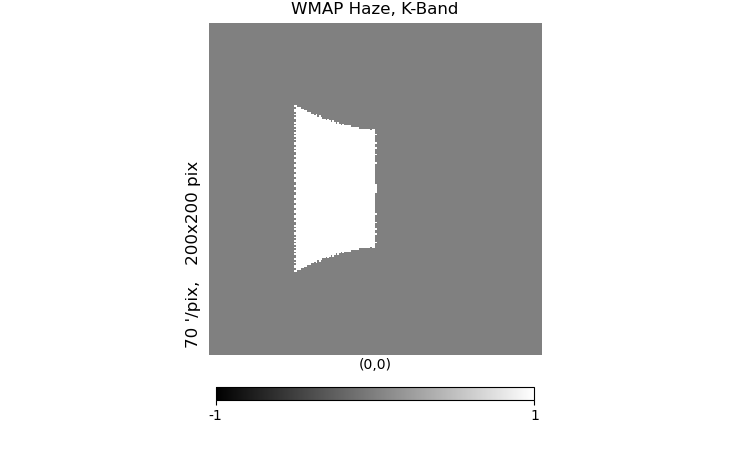

In [101]:
I_tot = np.zeros([NPIX])
#I_tot[side_filter_theta] = 1
#I_tot[side_filter_phi] = 1
I_tot[side_y_plus] = 1
f1 = plt.figure(figsize=(7.5,4.5), dpi=100)
#https://healpy.readthedocs.io/en/latest/generated/healpy.visufunc.gnomview.html
hp.gnomview(I_tot, fig=f1, title="WMAP Haze, K-Band", reso=70, rot=(0,0,0), cmap="gray", min=-1, max=1)